Desarrolle un crawler para el sitio web del Diario Jornada, que almacene la información de las secciones más relevantes de la página en una base de datos. Exponga una API que permita consultar los datos de acuerdo a ciertos parámetros.
Además resolver y graficar las siguientes operaciones:
1. Mostrar cuales son las 5 noticias más relevantes según cantidad de visitas a nivel global y por sección.
2. Mostrar como están distribuidas las palabras de cierto artículo.
3. Mostrar el número promedio, máximo y mínimo de palabras, sentencias, párrafos de un conjunto de noticias de su preferencia

Para desarrollar un crawler usaremos la libreria **Scrapy**, el proyecto con la araña se encuentra en la carpeta **dss_diario**.

Lo que haremos con el siguiente comando es correr la araña para dejar las noticias obtenidas en un archivos llamado **noticias.json** que posteriormente importaremos a una base en mongo.

In [11]:
%%bash
cd dss_diario
scrapy crawl jornada-spider -o ../noticias.json

Una vez que obtenemos el JSON con las noticias porcedemos a cargarlo dentro de la base diario-jornada

In [65]:
from pymongo import MongoClient
from random import randint
import json
import requests
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from functools import reduce

In [16]:
client = MongoClient(port=27017)
db=client.diario
collection_noticia = db.noticia

with open('noticias.json') as f:
    data = json.load(f)

for noticia in data:
    collection_noticia.insert_one(noticia)
client.close()

Para correr la api que vamos a utilizar para consumir las noticias, vamos a correr en otra terminal el servidor de Flask

Esto se hace con el siguiente comando, sobre la carpeta **api**:
> python api.py

Una vez que tenemos el servidor corriendo procedemos a sacar las noticias y realizar los graficos solicitados.

Mostrar cuales son las 5 noticias más relevantes según cantidad de visitas a nivel global y por sección.

In [28]:
response = requests.get('http://127.0.0.1:5000/noticias/')
noticias = response.json()

noticias.sort(key=lambda x: x['hits'], reverse=True)
print("Noticias mas relevantes a nivel global")
noticias_ord = ["Titulo: {0}, Leida {1} veces".format(noticia['titulo'],
                                                    noticia['hits']) for noticia in noticias[:5]]
for noticia in noticias_ord:
    print(noticia)

Noticias mas relevantes a nivel global
Titulo: Conducía alcoholizado, mató a una persona y una Cámara se apresta a darle la “probation”, Leida 13429 veces
Titulo: Dos mujeres y el desafío de encontrar a su madre, que desapareció en 1994, Leida 11866 veces
Titulo: Inseguridad en Trelew: el baldío del terror, Leida 4157 veces
Titulo: Temor en Bariloche por presencia de jabalíes en los barrios: mataron a un perro, Leida 3876 veces
Titulo: Descubren dos "fantasmas" en un cementerio con Google Street View, Leida 3139 veces


In [35]:
for categoria in ['deportes','provincia','economía','país & mundo','policiales','sociedad']:
    response = requests.get('http://127.0.0.1:5000/noticias/categoria/{}/'.format(categoria))
    noticias = response.json()

    noticias.sort(key=lambda x: x['hits'], reverse=True)
    print("Noticias más relevantes en la categoria {}".format(categoria))
    noticias_ord = ["Titulo: {0}, Leida {1} veces".format(noticia['titulo'],
                                                        noticia['hits']) for noticia in noticias[:5]]
    for noticia in noticias_ord:
        print(noticia)
    print("============================")

Noticias más relevantes en la categoria deportes
Titulo: Luna, la arquera que hizo tres goles en un partido, Leida 1262 veces
Titulo: Brown: Hugo Barrientos, afuera, Leida 624 veces
Titulo: Maradona y un debut soñado, Leida 576 veces
Titulo: Somos España: Boca-River, como único atractivo, Leida 415 veces
Titulo: El Mar y Valle colaboró con el Materno Infantil, Leida 308 veces
Noticias más relevantes en la categoria provincia
Titulo: Causa Revelación: denunciaron a los fiscales Nápoli e Iturrioz ante el Consejo de la Magistratura, Leida 1724 veces
Titulo: Massoni dijo que a Rosa Acuña la violaron y la prendieron fuego viva para matarla, Leida 1685 veces
Titulo: Esquel: denunciaron que el municipio cobró un bono por la garrafa social, Leida 1075 veces
Titulo: Llega hoy a Trelew el vuelo de Córdoba , Leida 814 veces
Titulo: Trelew: remueven basura y chatarra en un baldío conflictivo, Leida 802 veces
Noticias más relevantes en la categoria economía
Titulo: Comienza el mega juicio contra Vo

Mostrar como están distribuidas las palabras de cierto artículo

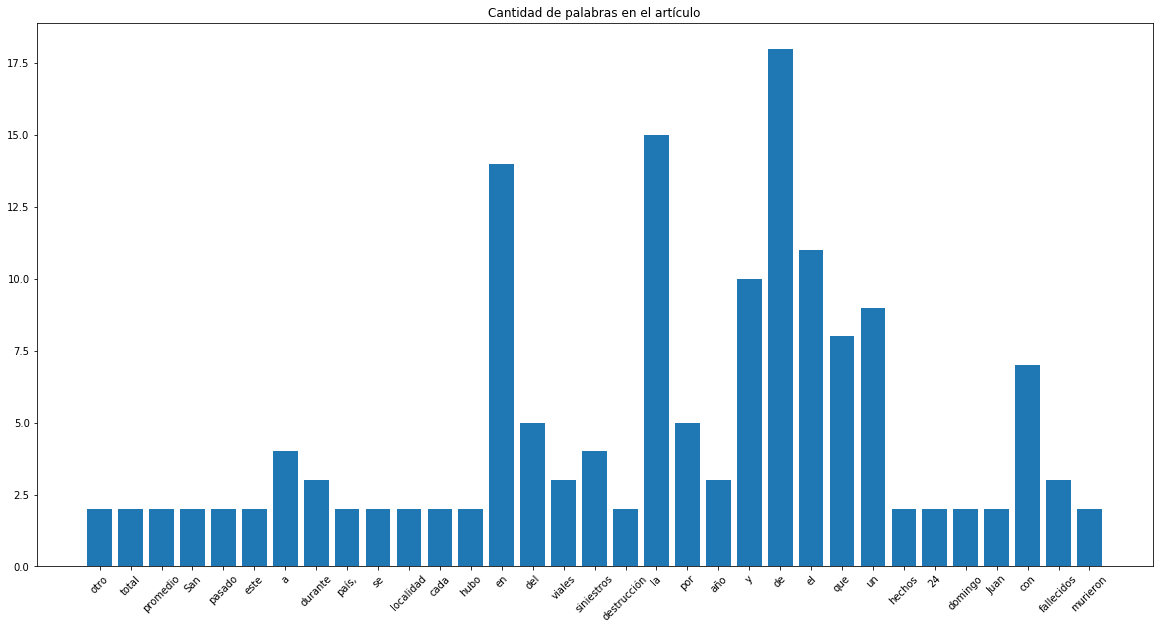

In [60]:
#Elegimos un artículo de la base usando su id
response = requests.get('http://127.0.0.1:5000/noticias/219524')
noticia = response.json()

palabras = noticia['cuerpo'].split()
diccionario_palabras = Counter(palabras)
palabras_grafico = []
cantidad_grafico = []
for palabra, cantidad in diccionario_palabras.items():
    if cantidad > 1: #Nos quedamos con las palabras que aparecen más que 1 vez
        palabras_grafico.append(palabra)
        cantidad_grafico.append(cantidad)

#Agrandamos el gráfico para que despues se vean las palabras.
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size
plt.bar(np.arange(len(cantidad_grafico)), cantidad_grafico)  # Dibujamos el gráfico de barras
plt.title('Cantidad de palabras en el artículo')  # Colocamos el título
plt.xticks(np.arange(len(cantidad_grafico)), palabras_grafico, rotation = 45)
plt.show()

Mostrar el número promedio, máximo y mínimo de palabras, sentencias, párrafos de un conjunto de noticias de su preferencia

In [75]:
response = requests.get('http://127.0.0.1:5000/noticias/categoria/deportes')
noticias = response.json()

#Calculamos el promedio de palabras en cada noticia
promedio_palabras = sum(len(noticia['cuerpo'].split()) for noticia in noticias)/len(noticias)

#obtenemos el numero maximo y minimo de palabras por articulo
cant_max_palabras = 0
cant_min_palabras = 1000000
for noticia in noticias:
    cant_palabras_articulo = len(noticia['cuerpo'].split())
    if cant_palabras_articulo > cant_max_palabras:
        cant_max_palabras = cant_palabras_articulo
    if cant_palabras_articulo < cant_min_palabras:
        cant_min_palabras = cant_palabras_articulo

print("La cantidad promedio de palabras de un articulo es de {}".format(promedio_palabras))
print("El articulo con menos palabras posee {} palabras,\
      mientras que el más extenso cuenta con {} palabras".format(cant_min_palabras,cant_max_palabras))

La cantidad promedio de palabras de un articulo es de 326.70588235294116
El articulo con menos palabras posee 115 palabras,      mientras que el más extenso cuenta con 708 palabras


**Nota:** El numero de sentencias y parafos no pudo ser determinado ya que se quitaron los caracteres especiales durantes la toma de datos en la página.